In [76]:
library(deSolve)
library(rstan)
library(viridis)
options(mc.cores = parallel::detectCores())

In [77]:
theta <- list(vmax       = 0.075,
              nuthalfsat = 0.3,
              graz       = 0.02,
              mort_p     = 0.02,
              mort_z     = 0.03,
              irr        = 0.8)

x <- c(N = 0.6,
       P = 0.15,
       Z = 0.23)

T  <- 2*365
dt <- 1
t  <- seq(0,T,dt)

i_n = 1
i_p = 2
i_z = 3

In [78]:
dxdt <- function(t,x,theta){
    with(as.list(c(x,theta)),{
        light   = 1 + 0.5*(irr*sin(pi*((t-81.25)/182.5)) - irr)
        growth  = (vmax*N/(nuthalfsat + N))*light*P
        grazing = graz*P*Z
        ploss   = mort_p*P
        zloss   = mort_z*Z*Z
        
        list(c(-growth + ploss + zloss,
               growth - grazing - ploss,
               grazing - zloss)) })}

In [79]:
x <- as.data.frame(ode(y=x, times=t, func=dxdt, parms=theta))

In [80]:
iobs <- sort(sample(1:length(t), 20)) 
tobs <- t[iobs]
iobsvar <- c(i_p,i_z)

sigma <- c(0.03,0.03)

obs <- cbind(x$P[iobs] + rnorm(length(iobs),sd=sigma[1]),
             x$Z[iobs] + rnorm(length(iobs),sd=sigma[2]))

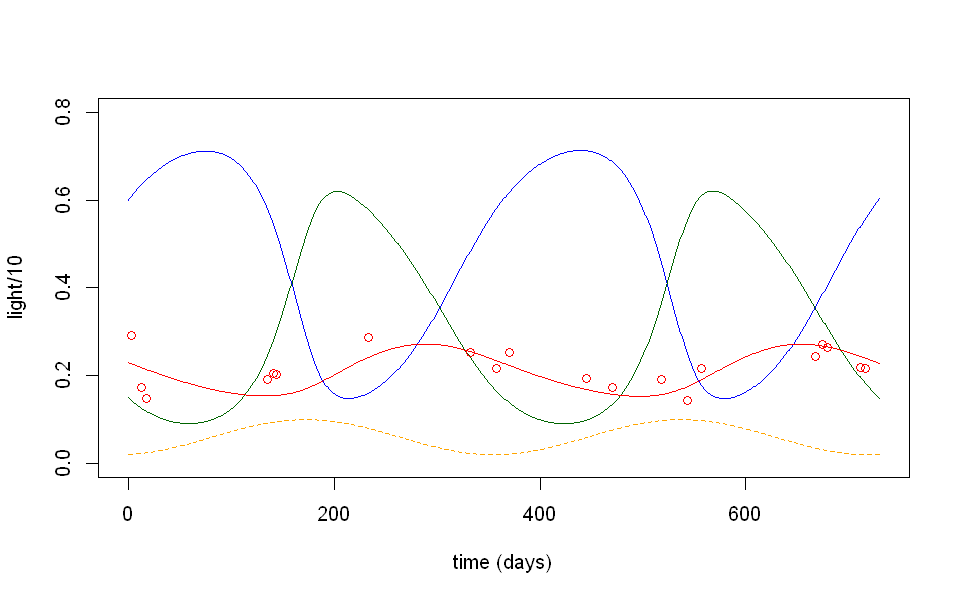

In [81]:
options(repr.plot.width=8, repr.plot.height=5)
light <- 1 + 0.5*(theta$irr*sin(pi*((t-81.25)/182.5)) - theta$irr)

plot(t,light/10,type='l',ylim=c(0,0.8),lty=2,col='orange',xlab='time (days)')
lines(t,x$N,col='blue')
lines(t,x$P,col='dark green')
lines(t,x$Z,col='red')

points(tobs,obs[,length(iobsvar)],col='dark green')
points(tobs,obs[,length(iobsvar)],col='red')

In [84]:
stan_code = "functions {
   real[] npz(real t,       // time
              real[] x,     // state
              real[] theta, // parameters
              real[] x_r,   // fixed real data (empty)
              int[] x_i) {  // fixed integer data (empty)
   
    /*
    guide to theta:
    theta[1]:  vmax         maximum growth rate in Michaelis Menten formulation
    theta[2]:  nuthalfsat   nutrient half saturation in Michaelis Menten formulation
    theta[3]:  graz         zooplankton grazing rate
    theta[4]:  mort_p       phytoplankton mortality rate
    theta[5]:  mort_z       zooplankton mortality rate
    theta[6]:  irr          light amplitude
    */

    real n = fmax(0.0, x[1]);
    real p = fmax(0.0, x[2]);
    real z = fmax(0.0, x[3]);

    real light = 1.0 + 0.5*(theta[6]*sin(pi()*((t-81.25)/182.5))-theta[6]); 
    real growth = theta[1]*n/(theta[2]+n) * light * p;
    real grazing = theta[3]*p*z;
    real ploss = theta[4]*p;
    real zloss = theta[5]*z*z;
    
    return {-growth+ploss+zloss,growth-grazing-ploss,grazing-zloss};
  }
}
data {
    int<lower=0> nobs;               // number of timesteps with observations
    real tobs[nobs];                 // obs times
    int<lower=0> nobsvar;            // number of observed variables
    int<lower=0> iobsvar[nobsvar];   // index of observed variable (N=1, P=2, Z=3)
    real<lower=0> obs[nobs,nobsvar]; // observed variable at measurement times
}
parameters {
    real<lower=0> vmax;
    real<lower=0> nuthalfsat;
    real<lower=0> graz;
    real<lower=0> mort_p;
    real<lower=0> mort_z;
    real<lower=0,upper=1> irr;
    real<lower=0> x0[3];            // initial conditions
    real<lower=1E-15> sigma[nobsvar];   // obs error
}
transformed parameters {
    //real theta[6];   // parameters
    //real x[nobs, 3];
    real theta[6] = {vmax,nuthalfsat,graz,mort_p,mort_z,irr};
    real x[nobs, 3] = integrate_ode_rk45(npz, x0, 0, tobs, theta,
                                         rep_array(0.0, 0), rep_array(0, 0),
                                         1e-5, 1e-4, 1e4);
}
model {
    vmax       ~ normal(0.1, 0.1);
    nuthalfsat ~ uniform(0.0, 1.0);
    graz       ~ normal(0.01, 0.01);
    mort_p     ~ normal(0.01, 0.01);
    mort_z     ~ normal(0.01, 0.01);
    irr        ~ uniform(0.0, 1.0);
    x0[1:3]    ~ normal(0.1, 0.1);
    for (iobs in 1:nobs){
        obs[iobs,] ~ normal(x[iobs,iobsvar], sigma);
    }
}"

In [85]:
mod <- stan_model(model_code = stan_code)

In [86]:
data <- list(obs=obs,
             nobs=length(tobs),
             tobs=tobs,
             nobsvar=ncol(obs),
             iobsvar=iobsvar)

In [87]:
mcmc <- sampling(mod,data=data,open_progress=TRUE)

Warning message:
"There were 684 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup"Warning message:
"Examine the pairs() plot to diagnose sampling problems
"Warning message:
"Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess"

In [88]:
mcmc

Inference for Stan model: e35dd66afce58e4673f555ba96067cde.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
vmax        0.08    0.00 0.02  0.05  0.07  0.08  0.09  0.14   441 1.01
nuthalfsat  0.32    0.01 0.23  0.04  0.14  0.24  0.44  0.91   485 1.01
graz        0.01    0.00 0.00  0.01  0.01  0.01  0.02  0.02  1318 1.00
mort_p      0.02    0.00 0.00  0.01  0.01  0.02  0.02  0.03  1371 1.00
mort_z      0.02    0.00 0.01  0.01  0.02  0.02  0.02  0.03  1340 1.00
irr         0.91    0.00 0.07  0.73  0.87  0.92  0.96  1.00  1301 1.00
x0[1]       0.47    0.00 0.06  0.35  0.44  0.48  0.51  0.59   780 1.00
x0[2]       0.15    0.00 0.02  0.11  0.13  0.14  0.16  0.19  1495 1.00
x0[3]       0.24    0.00 0.02  0.21  0.23  0.24  0.26  0.29  1951 1.00
sigma[1]    0.04    0.00 0.01  0.03  0.03  0.04  0.04  0.06  1232 1.00
sigma[2]    0.04    0.00 0.01  0.03  0.03

In [89]:
post <- extract(mcmc)

[1] 4000   20    3

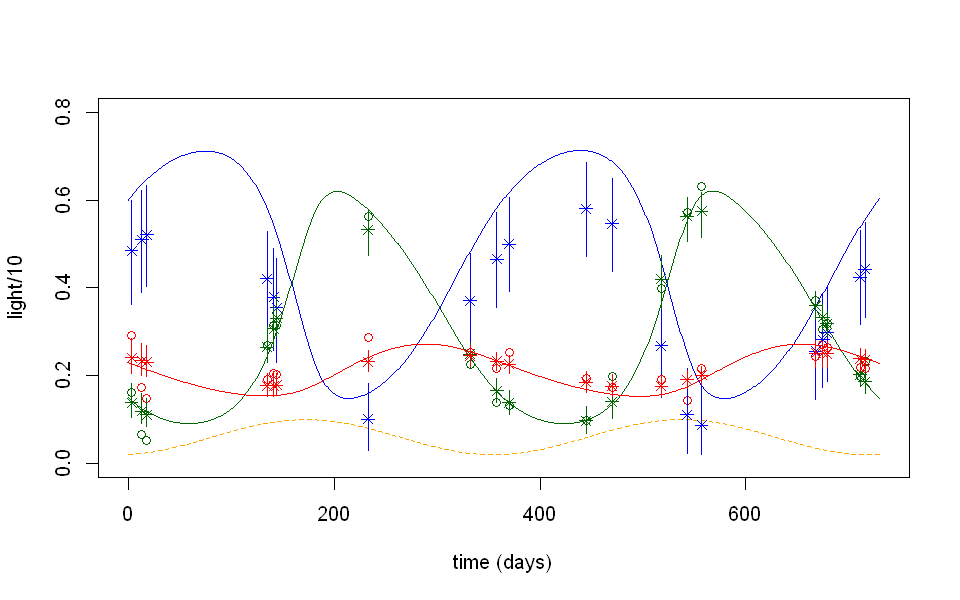

In [102]:
options(repr.plot.width=8, repr.plot.height=5)
light <- 1 + 0.5*(theta$irr*sin(pi*((t-81.25)/182.5)) - theta$irr)

plot(t,light/10,type='l',ylim=c(0,0.8),lty=2,col='orange',xlab='time (days)')
lines(t,x$N,col='blue')
lines(t,x$P,col='dark green')
lines(t,x$Z,col='red')

points(tobs,obs[,1],col='dark green')
points(tobs,obs[,2],col='red')

qs <- c(0.025,0.5,0.975)
dim(post$x)

q_n <- apply(post$x[,,1],2,function(x) quantile(x,probs=qs))
q_p <- apply(post$x[,,2],2,function(x) quantile(x,probs=qs))
q_z <- apply(post$x[,,3],2,function(x) quantile(x,probs=qs))
    
points(tobs,q_n[2,],pch=8,col='blue')
    segments(x0=tobs,x1=tobs,y0=q_n[1,],y1=q_n[3,],col='blue')
points(tobs,q_p[2,],pch=8,col='dark green')
    segments(x0=tobs,x1=tobs,y0=q_p[1,],y1=q_p[3,],col='dark green')
points(tobs,q_z[2,],pch=8,col='red')
    segments(x0=tobs,x1=tobs,y0=q_z[1,],y1=q_z[3,],col='red')

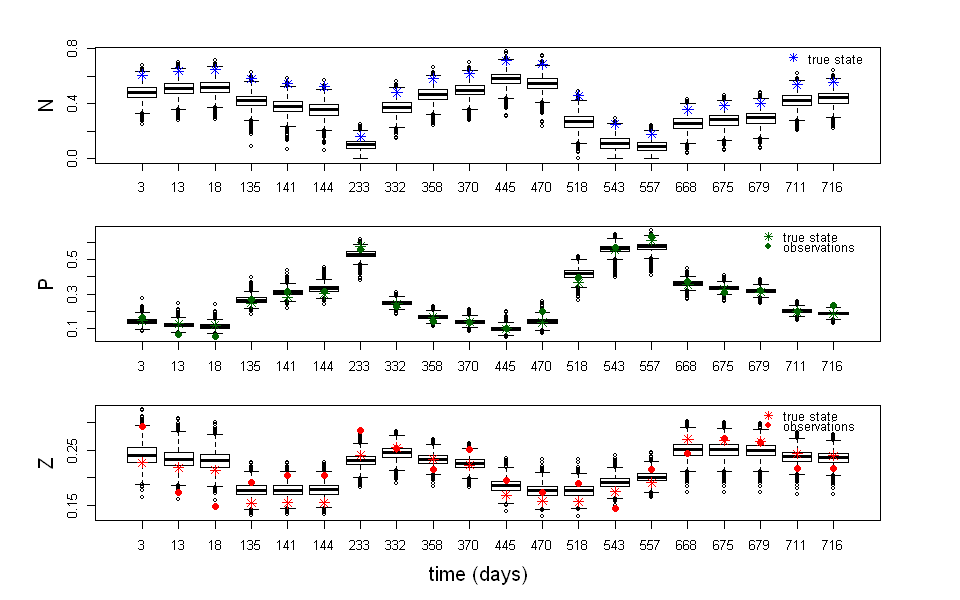

In [126]:
options(repr.plot.width=8, repr.plot.height=5)
par(mfrow=c(3,1),mar=c(3,4,1,3),oma=c(2,2,2,2))
boxplot(post$x[,,1],names=tobs)
    points(x$N[iobs],col='blue',pch=8,cex=1.2)
    legend('topright',bty='n',legend=c('true state'),col='blue',pch=8)
    mtext('N',side=2,line=2.5)
boxplot(post$x[,,2],names=tobs)
    points(x$P[iobs],col='dark green',pch=8,cex=1.2)
    points(obs[,1],col='dark green',pch=19,cex=1.2)
    legend('topright',bty='n',legend=c('true state','observations'),col='dark green',pch=c(8,19))
    mtext('P',side=2,line=2.5)
boxplot(post$x[,,3],names=tobs)
    points(x$Z[iobs],col='red',pch=8,cex=1.2)
    points(obs[,2],col='red',pch=19,cex=1.2)
    legend('topright',bty='n',legend=c('true state','observations'),col='red',pch=c(8,19))
    mtext('Z',side=2,line=2.5)
mtext(outer=TRUE,side=1,'time (days)')